In [5]:
#Importaciones de librerias
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier #Algoritmo del árbol de decisión
from sklearn.metrics import f1_score
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score


In [6]:
# Carga del dataset
# Lee CSV, tratando valores missing
df=pd.read_csv('./company_data.csv', na_values=['?', 'None', 'nan'])
df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.089414,0.65665,0.18322,1.3328,-47.9670,0.0,0.112660,0.52288,2.2558,0.343350,...,0.280410,0.26042,0.74418,0.22586,6.7518,6.7353,89.083,4.0973,8.4735,0
1,0.038013,0.90904,0.29719,1.5489,3.1553,0.0,0.050146,0.10006,7.2487,0.090961,...,0.006490,0.41790,0.99309,4.01990,33.7090,15.5180,27.263,13.3880,44.9160,0
2,0.070791,0.57945,0.18817,1.4960,-11.4320,0.0,0.089941,0.72577,2.0477,0.420550,...,0.053486,0.16833,0.93810,0.00000,8.2680,10.9890,67.619,5.3979,4.7346,0


In [7]:
df.isnull().sum()# Cuenta valores nulos por columna (pero no se usa el resultado)
df = df.replace([np.inf, -np.inf], np.nan) # Reemplaza infinitos por NaN
umbral = 0.5 * len(df) 
df = df.dropna(axis=1, thresh=umbral) # Elimina columnas con más del 50% de valores missing
df = df.fillna(df.median()) # Rellena valores missing con la mediana de cada columna

In [8]:
print(f"Distribución original de clases:")
print(df['Y'].value_counts())
print(f"Porcentaje de Y: {df['Y'].mean()*100:.2f}%")

Distribución original de clases:
Y
0    32284
1     2091
Name: count, dtype: int64
Porcentaje de Y: 6.08%


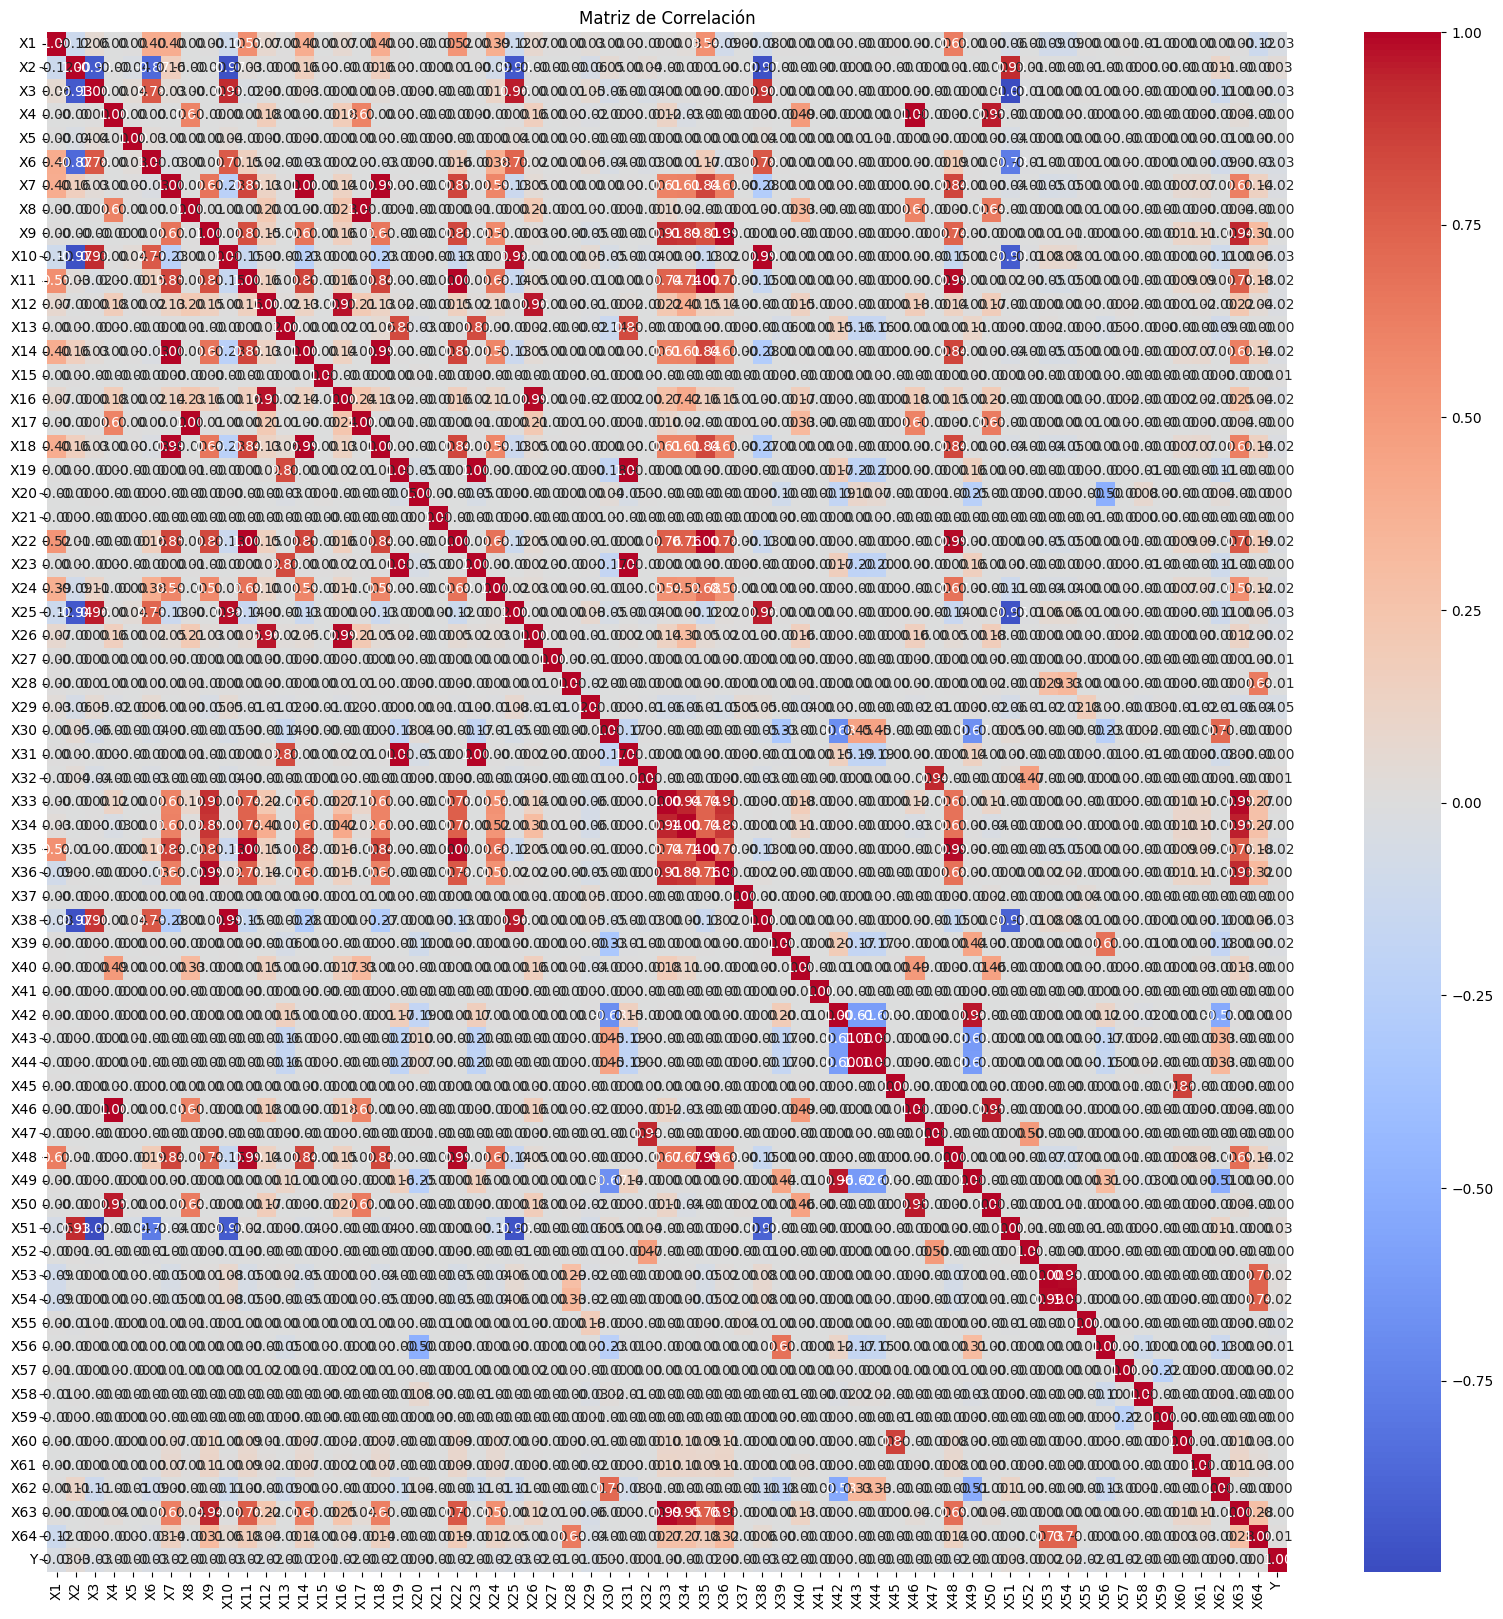


Matriz de Correlación Numérica:
           X1        X2        X3        X4        X5        X6        X7  \
X1   1.000000 -0.119376  0.058795  0.000375  0.003621  0.404118  0.398662   
X2  -0.119376  1.000000 -0.928321 -0.001519 -0.037726 -0.865130  0.163649   
X3   0.058795 -0.928321  1.000000  0.002233  0.040345  0.779209  0.033953   
X4   0.000375 -0.001519  0.002233  1.000000  0.001826  0.000334  0.000187   
X5   0.003621 -0.037726  0.040345  0.001826  1.000000  0.031009  0.001862   
..        ...       ...       ...       ...       ...       ...       ...   
X61  0.000401 -0.001236  0.000164  0.004488  0.000045  0.000428  0.073576   
X62  0.001071  0.106946 -0.114634 -0.000245 -0.005234 -0.092490  0.000501   
X63  0.002624 -0.002965  0.003683  0.039111  0.000604  0.000760  0.624225   
X64 -0.121164 -0.000058  0.001183 -0.000252  0.000214 -0.026351  0.143115   
Y   -0.034088  0.034967 -0.034868 -0.002275 -0.001392 -0.034632 -0.017737   

           X8        X9       X10  ...    

In [9]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 20))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


print("\nMatriz de Correlación Numérica:")
print(correlation_matrix)

In [10]:
 # --- DEFINICIÓN DE VARIABLES PREDICTORAS (features) ---

#X1: net profit / total assets = utilidad_neta / total_activos
    #X2: total liabilities / total assets = total_pasivos / total_activos
    #X3: working capital / total assets = (activo_corriente - pasivo_corriente) / total_activos
    #X4: current assets / short-term liabilities = activo_corriente / pasivo_corriente
    #X6: retained earnings / total assets = utilidad_neta / total_activos
    #X8: book value of equity / total liabilities = patrimonio / total_pasivos
    #X9: sales / total assets = ventas_totales / total_activos
    #X10: equity / total assets = patrimonio / total_activos
    #X17: total assets / total liabilities = total_activos / total_pasivos
    #X18: gross profit / total assets = (ventas_totales - costo_ventas) / total_activos
    #X19: gross profit / sales   = (ventas_totales - costo_ventas) / ventas_totales
    #X23: net profit / sales  = utilidad_neta / ventas_totales
    #X44: (receivables * 365) / sales   =  (cuentas_por_cobrar * 365) / ventas_totales
    #X50: current assets / total liabilities = activo_corriente / total_pasivos
    #X51: short-term liabilities / total assets = pasivo_corriente / total_activos
    #X60: sales / inventory = ventas_totales / inventario_final
    #X61: sales / receivables = ventas_totales / cuentas_por_cobra
variablex = df[["X1", "X2", "X3", "X4", "X6", "X8", "X9", "X10", "X17", "X18", "X19", "X23",  "X44", "X50", "X51", "X60", "X61"]].values
variabley = df[["Y"]].values

In [11]:
    # --- DIVISIÓN DE DATOS ---
    # 67% para entrenamiento, 33% para prueba
    # stratify=variabley asegura que la proporción de clases se mantenga en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(variablex, variabley, test_size = 0.33, random_state = 42, stratify=variabley)

In [12]:
  # --- BALANCEO DE CLASES CON SMOTE ---
    # SMOTE crea muestras sintéticas de la clase minoritaria para equilibrar el dataset
   
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [13]:
# --- CREACIÓN Y ENTRENAMIENTO DEL MODELO ---
model = DecisionTreeClassifier(criterion="log_loss", random_state=42, max_depth=10, class_weight='balanced')
model.fit(X_resampled, y_resampled)

DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, random_state=42)

In [14]:
# --- PREDICCIÓN Y EVALUACIÓN ---
y_pred = model.predict(X_test)
#y_prob = model.predict_proba(X_test)[:, 1]
y_prob = model.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva (índice 1)

In [15]:

    # --- REPORTE DE RESULTADOS ---
print("===DECISION TREE===")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    

===DECISION TREE===
Matriz de confusión:
 [[8220 2434]
 [ 296  394]]


In [16]:
porcent = model.score(X_test, y_test)
print(f"El modelo obtuvo {porcent*100} % de precision para clasificar")

f1 = f1_score(y_test, y_pred)
print(f"El modelo obtuvo un indice F1 Score de: {f1}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
    

El modelo obtuvo 75.93441466854725 % de precision para clasificar
El modelo obtuvo un indice F1 Score de: 0.22399090392268334
ROC AUC Score: 0.7260
Model accuracy score with criterion gini index: 0.7593


In [17]:
# Reporte completo con varias métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     10654
           1       0.14      0.57      0.22       690

    accuracy                           0.76     11344
   macro avg       0.55      0.67      0.54     11344
weighted avg       0.92      0.76      0.82     11344

